# Imports

In [1]:
from pathlib import Path
import numpy as np
import torch
import math
from tqdm import tqdm
from torchvision.datasets import CocoDetection
import matplotlib.pyplot as plt
import torchvision

In [2]:
from abbyy_course_cvdl_t3.coco_text import COCO_Text
from abbyy_course_cvdl_t3 import coco_evaluation
from abbyy_course_cvdl_t3.utils import evaluate_ap_from_cocotext_json
from abbyy_course_cvdl_t3.utils import dump_detections_to_cocotext_json

In [3]:
cd ../task2

/home/alexander/computerScience/phystech/9sem/abbyy/course_cvdl/task2


In [4]:
import abbyy_course_cvdl_t2
from abbyy_course_cvdl_t2.convert import PointsToObjects, ObjectsToPoints
from abbyy_course_cvdl_t2.impl.train import train
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform
from abbyy_course_cvdl_t2.network import CenterNet
from abbyy_course_cvdl_t2.loss import CenterNetLoss

In [5]:
cd ../task3

/home/alexander/computerScience/phystech/9sem/abbyy/course_cvdl/task3


# Data

In [6]:
base = Path("/home/alexander/Downloads/coco2014/")
anno_path = base / 'cocotext.v2.json'
images_path = base / 'images/train2014'

assert anno_path.exists(), "Set your own path to annotation"
assert images_path.exists(), "Set your own path to images"


In [7]:
ct = COCO_Text(anno_path)

loading annotations into memory...
0:00:02.482653
creating index...
index created!


In [8]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]
        img[
                yc - hy//2 - thick : yc - hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val
        img[
                yc + hy//2 - thick : yc + hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val

        img[
                yc - hy//2 : yc + hy//2, 
                (xc - wx//2 - thick): (xc - wx//2 + thick), 
        ] = val
        img[
                yc - hy//2 : yc + hy//2, 
                xc + wx//2 - thick: xc + wx//2 + thick, 
        ] = val
    return img
        
        

In [9]:
n_classes=2

In [10]:
ds_train = CocoTextDetection(
    Path("/home/alexander/Downloads/coco2014/images/train2014"),
    Path("/home/alexander/Downloads/coco2014/cocotext.v2.json"),
    transforms=CocoDetectionPrepareTransform(size=(256,256), #ids_map = {1: 0, 0: 0}
),
    area_fraction_threshold=1/32/32
)

In [11]:
ds_val = CocoTextDetection(
    images_path,
    Path(anno_path),
    transforms=CocoDetectionPrepareTransform(size=(256,256), #ids_map = {1: 0, 0: 0}
    ),
    area_fraction_threshold=1/32/32,
    split='val'
)

In [12]:
x, y = ds_train[6]

In [13]:
y[:10]

tensor([[133.8933,  60.5600,  12.5333,  13.4400,   1.0000,   1.0000],
        [131.5200, 156.7800,  11.5200,  19.8800,   1.0000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])

/tmp/ipykernel_58128/4024544524.py:11: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  yc - hy//2 - thick : yc - hy//2 + thick,
/tmp/ipykernel_58128/4024544524.py:12: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  xc - wx//2 : xc + wx//2,
/tmp/ipykernel_58128/4024544524.py:15: UserWarning: __floordiv__ is deprecated, and its behavior wil

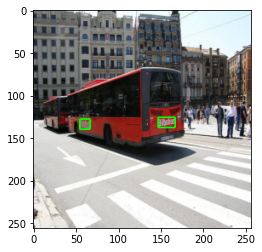

In [14]:
rnd = lambda x: torch.round(x).long()

plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(y[:, 0]), rnd(y[:, 1]), rnd(y[:, 2]), rnd(y[:, 3]) 
))
#plt.imshow(x.permute(1, 2, 0))

In [15]:
trainloader = torch.utils.data.DataLoader(
    ds_train, batch_size=2, shuffle=True
)

In [16]:
valloader = torch.utils.data.DataLoader(
    ds_val, batch_size=1, shuffle=False
)

# Learning

In [17]:
net = CenterNet(head_kwargs={'c_classes': n_classes}, nms_kwargs={'kernel_size': 5})
crit = CenterNetLoss(obj_to_points=ObjectsToPoints(num_classes=n_classes))

In [18]:
net = train(ds_train, net=net, criterion=crit, batch_size=64, epochs=120, device=torch.device('cuda:0'), lr=1e-3)

epoch 0|0; total loss:1257.8092041015625
last losses: [37564.76953125, 54.00093460083008, 115.50421142578125]
epoch 0|30; total loss:1886.2388916015625
last losses: [322.9469909667969, 43.29220962524414, 46.006858825683594]
epoch 0|60; total loss:327.7005310058594
last losses: [213.59347534179688, 42.46577453613281, 35.97744369506836]
epoch 0|90; total loss:288.3876647949219
last losses: [177.9588623046875, 36.91019821166992, 42.914451599121094]
epoch 0|120; total loss:259.88409423828125
last losses: [148.3211669921875, 35.435909271240234, 29.899492263793945]
epoch 0|150; total loss:260.4101257324219
last losses: [199.35916137695312, 47.88767623901367, 47.61766815185547]
epoch 0|180; total loss:252.7855224609375
last losses: [168.62100219726562, 39.29122543334961, 45.07689666748047]
epoch 0|210; total loss:247.0817413330078
last losses: [132.96917724609375, 33.38351821899414, 47.74021530151367]
epoch 0|240; total loss:237.0569610595703
last losses: [150.7279052734375, 42.22948455810547

/home/alexander/computerScience/phystech/9sem/abbyy/course_cvdl/task2/abbyy_course_cvdl_t2/impl/train.py:64: UserWarning: nan loss! skip update
  warnings.warn("nan loss! skip update")


last loss: [nan, 93.0347900390625, nan]
Finished Training


In [ ]:
torch.save(net, 'centernet.pth')

In [ ]:
net = torch.load('centernet.pth').to('cuda:0')

In [19]:
anno = torch.load('anno.pt')
anno.shape

torch.Size([64, 100, 6])

In [20]:
inputs = torch.load('inputs.pt')
inputs.shape

(64, 3, 256, 256)

In [21]:
outputs = torch.load('outputs.pt')
outputs

array([[[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         ...,
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

        [[  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]],

        [[  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]],

        [[  0., 

In [29]:
for p in list(net.parameters()):
    if p.isnan().any():
        print(p)

Parameter containing:
tensor([[[[        nan,         nan,         nan,  ...,         nan,
                   nan,         nan],
          [        nan,         nan,         nan,  ...,         nan,
                   nan,         nan],
          [        nan,         nan,         nan,  ...,         nan,
                   nan,         nan],
          ...,
          [        nan,         nan,         nan,  ...,         nan,
                   nan,         nan],
          [        nan,         nan,         nan,  ...,         nan,
                   nan,         nan],
          [        nan,         nan,         nan,  ...,         nan,
                   nan,         nan]],

         [[        nan,         nan,         nan,  ...,         nan,
                   nan,         nan],
          [        nan,         nan,         nan,  ...,         nan,
                   nan,         nan],
          [        nan,         nan,         nan,  ...,         nan,
                   nan,         nan]

In [22]:
out = net(torch.from_numpy(inputs[0])[None, ...].to('cuda:0'))

In [23]:
o = out[0]

In [24]:
o[0, :]

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [25]:
o[1:3, 0]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [26]:
o[3:5, :]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[-inf, -inf, -inf,  ..., -inf, -inf, -inf],
         [-inf, -inf, -inf,  ..., -inf, -inf, -inf],
         [-inf, -inf, -inf,  ..., -inf, -inf, -inf],
         ...,
         [-inf, -inf, -inf,  ..., -inf, -inf, -inf],
         [-inf, -inf, -inf,  ..., -inf, -inf, -inf],
         [-inf, -inf, -inf,  ..., -inf, -inf, -inf]]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [27]:
backbone_out = net.backbone(torch.from_numpy(inputs[0])[None, ...].to('cuda:0'))

In [28]:
backbone_out

tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         ...,

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, n

In [ ]:
encoder_out = net.backbone.downscale(torch.from_numpy(inputs[0])[None, ...].to('cuda:0'))

In [ ]:
encoder_out

In [ ]:
list(net.backbone.downscale.md.children())

In [ ]:
list(net.backbone.downscale.md.parameters())[1]

In [ ]:
list(net.backbone.upscale.parameters())

In [ ]:
y = torch.from_numpy(inputs).to('cuda:0')
print(y)

with torch.no_grad():
    for layer in list(net.backbone.downscale.md.children()):
        x = layer(y)

        if x.isnan().any() or x.isinf().any():
            print(layer, x.shape, y.shape)
            break

        y = x.clone()

In [ ]:
torch.save(net, 'centernet.pth')

# Quality

## Preprocessing and visualization

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [ ]:
model = torch.load('centernet.pth')
model.to(torch.device('cpu'))
model.eval()

In [ ]:
img_id = 101243
img_meta = ct.loadImgs(ids=[img_id])[0]
plt.imshow(plt.imread(images_path / img_meta['file_name']))
annIds = ct.getAnnIds(imgIds=img_meta['id'])
anns = ct.loadAnns(annIds)
ct.showAnns(anns)
plt.title(f"GT: {img_meta['id']}")


In [ ]:
anns

In [ ]:
img, anno = ds_val[ds_val.ids.index(str(img_id))]

In [ ]:
preds = model(img[None, :])[0]

In [ ]:
prepared_preds = []
img_ids = []
pto = PointsToObjects()

for num, img_id in enumerate(tqdm(ds_val.ids)):
    img_id = int(img_id)
    img_meta = ct.loadImgs(ids=[img_id])[0]
    with torch.no_grad():
        x = ds_val[num][0]
        pred = model(
            x[None, ...]
        )[0]
        prepared_preds.append(
            pto(pred[None, ...])
        )
        img_ids.append(img_id)


In [ ]:
prepared_preds[0]

In [ ]:
prpr = []
for i in prepared_preds:
    unf = {}
    res = i[i[:, :, -1] > 0.2].detach()
    boxes = res[:, :4].clone()
    b = boxes.clone()
    boxes[:, 2] = (b[:, 2] - b[:, 0])
    boxes[:, 3] = (b[:, 3] - b[:, 1])
    unf['boxes'] = boxes.numpy()
    unf['scores'] = res[:, -1].detach().numpy()
    #print(unf['boxes'].shape[0], unf['scores'].shape[0])
    prpr.append(unf)

## Saving to json

In [ ]:
scores = np.concatenate([u['scores'] for u in prpr], axis=0)
boxes = np.concatenate([u['boxes'] for u in prpr], axis=0)

In [ ]:
image_ids = []
for num, i in enumerate(img_ids):
    image_ids += [i] * len(prpr[num]['boxes'])
image_ids = np.array(image_ids)

In [ ]:
print(len(image_ids.tolist()),
    len(boxes[:, 0].tolist()),
    len(boxes[:, 1].tolist()),
    len(boxes[:, 2].tolist()),
    len(boxes[:, 3].tolist()),
    len(scores.tolist()))

In [ ]:
dump_detections_to_cocotext_json(
    image_ids = image_ids.tolist(),
    xlefts=boxes[:, 0].tolist(),
    ytops=boxes[:, 1].tolist(),
    widths=boxes[:, 2].tolist(),
    heights=boxes[:, 3].tolist(),
    scores=scores.tolist(),
    path='predictions.json'
);
    

## AP calculation

In [ ]:
ap, prec, rec = evaluate_ap_from_cocotext_json(
    coco_text=ct,
    path='predictions.json'
)
print(f"Итоговый скор AP на val: {ap}")

In [ ]:
from matplotlib import pyplot as plt
plt.plot(prec, rec)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('PR curve')
plt.grid()